## Import Modules and Functions

In [1]:
# platform
from EphysSBIHelper.datautils import *
from EphysSBIHelper.plotutils import *
from EphysSBIHelper.simutils import *
from EphysSBIHelper.evalutils import *

import numpy as np
import torch
import pandas as pd
import importlib # mainly for reloading modules on the fly

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
    
# SBI
import sbi.utils as utils
from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi.analysis import pairplot,conditional_pairplot, conditional_corrcoeff, eval_conditional_density

# parallel processing
#from joblib import Parallel, delayed
#from tqdm.auto import tqdm

# warning handlings
#import warnings

In [2]:
# remove top and right axis from plot
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## Import Data

average tau = 0.014 s
R_input = 137.106MOhm


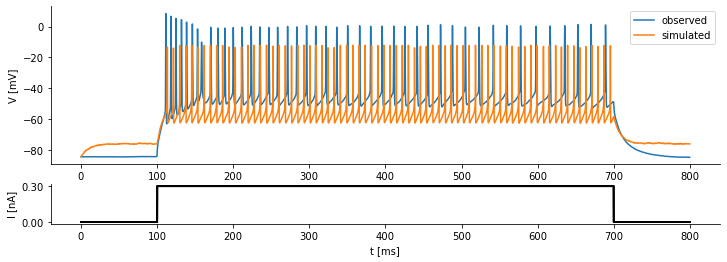

In [3]:
# Specify experimental and cellular parameters for the data set
cell_params = {"Description": "TestCell", "C": 1e-2, "Type": "Pvalb Calb1_1"}
exp_params = {"StimDur": 0.6, "StimOnset": 0.1, 
              "StimEnd": 0.7, "ObsTime" :1., 
              "IStep": 20*1e-12, "LiqJuncPotential": 15.4*1e-3,
              "Description": "04062020sample_16"}

# set file location
observations = '../data/04_06_2020_sample_16'

# select and prepare experimental data
ExpData = Data(observations, exp_params=exp_params, cell_params=cell_params)
ExpData.select_subset([2],t_cutoff=0.8)

# Inspect Dataset
# ExpData.inspect()

# Determine  and/or set R_in and \tau
ExpData.fitcell2observations(show=False)
ExpData.set_syn_current(136.8*1e6,13.6*1e-3)

# select observation
trace_obs = ExpData.Observations_selected[25]

# parameter guess that comes close-ish to the observation 
# -> might be informative for choosing a prior later
param_guess = {r'$g_{Na}$': 2.5040e+01, r'$g_{K}$': 2.7283e+01,
                r'$g_{M}$': 2.9853e-01, r'$g_{leak}$': 9.0264e-02,
                r'$\tau_{max}$': 1.6638e+00, r'$V_{T}$': -6.5674e+01,
                r'$E_{leak}$': -7.5082e+01, 'time constant factor': 0.1116e+00}

param_vec = np.array(list(param_guess.values())).reshape(1,-1)

# simulating parameter guess and comparing it to observation
trace_sim = runHH(param_vec, trace=trace_obs)
axs = trace_obs.inspect(label="observed")
trace_sim.inspect(label="simulated", axes=axs)
plt.show()

## Simulate Training Data

In [412]:
# specify prior based on parameter guess and biologically sensible ranges

# example 10 param prior
prior_min = [.5, 1e-4, 1e-4, 1e-4, 50, -90, -110, 0.1,-110*1e-3, 5*1e-10]
prior_max = [80., 30, 0.6, 0.6, 3000, -40, -50, 3,-50*1e-3, 1*1e-8]

# example 8 param prior
#prior_min = [.5, 1e-4, 1e-4, 1e-4, 50, -90, -110, 0.1]
#prior_max = [80., 30, 0.6, 0.6, 3000, -40, -50, 3]

prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

In [420]:
# run simulations from the prior samples and collect the results
#theta = prior.sample((350000,))

#summaries = simulate_and_summarise_batches(theta, syn_current=trace_obs.get_syn_current(), 
#                                           num_workers=2, batch_size=100, summary_func="v2",
#                                          using="br2")

#stats_obs = pd.DataFrame([pd.Series(trace_obs.summarise(summary_func="v2"))])
#stats_sim = pd.DataFrame(np.array(summaries), columns=stats_obs.columns)
#params_sim = pd.DataFrame(np.array(theta), columns=list(param_guess.keys())+[r"$V_0$",r"$A_{Soma}$"])
#sim_results_df = pd.concat([params_sim, stats_sim], axis=1)

In [416]:
#PATH = "../data/saved_stats/{0}_{1}paramprior_{2}_stats_{3}_{4}.csv".format(ExpData.Description, 
#                                                                            len(params_sim.columns),
#                                                                            len(stats_sim.columns), 
#                                                                            summaries.shape[0],
#                                                                            "v2")

# export stats to csv
#sim_results_df.to_csv(PATH, index=False)

In [425]:
# import alrady simulated (summary-stat,parameter) pairs from csv
num_sims = 350000
num_stats = 20 # or 20 depending on if calculate_summary "v1" or "v2" was used.
num_params = 10 # or 8 depending on if A_Soma and V0 were part of the prior

PATH = "../data/saved_stats/{0}_{1}paramprior_{2}_stats_{3}_{4}.csv".format(ExpData.Description, 
                                                                            num_params,
                                                                            num_stats, 
                                                                            num_sims,
                                                                            "v2")
# import and preview simulation results
sim_results_df = pd.read_csv(PATH)
sim_results_df.head()

# split data into observed summary stats (stats_obs), 
# model parameters (params_sim) and summary stats of simulated traces (stats_sim)
stats_obs = pd.DataFrame([pd.Series(trace_obs.summarise(summary_func="v2"))])
params_sim, stats_sim = sim_results_df.iloc[:,:num_params], sim_results_df.iloc[:,num_params:]
params_sim.head()
stats_sim.head()

,AP threshold,AP amplitude,AP width,AHP,3rd AP threshold,3rd AP amplitude,3rd AP width,3rd AHP,AP count,AP amp adapt,AP average amp adapt,AP CV,ISI adapt,ISI CV,latency,SFA,rest $V_{m}$ mean,$V_{m}$ mean,$V_{m}$ std,$V_{m}$ skewness
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-82.775568,-75.383189,0.100597,-15.382567
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-99.968501,-85.399025,0.508180,-13.762998
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-93.292216,-86.795684,0.086017,-15.554770
3,-56.589268,93.495230,0.24,-26.262010,-56.468278,92.756466,0.24,-26.405316,74.0,0.00425,0.495860,-5.068969,0.020907,-2.159302,1.863305,0.850000,-90.691264,-67.327956,287.553640,3.865848
4,-36.725383,87.045178,1.08,-23.982191,-35.939562,83.951713,1.00,-24.287033,68.0,-0.03851,0.493549,-5.329503,-0.014458,-3.633967,1.201470,0.942857,-54.283155,-37.213081,797.792439,1.832375


## Clean Data and select suitable Summary Statistics

In [426]:
# remove -infs in ISI and ISI CV
no_infs = ~np.any((stats_sim == -np.inf),axis=1)
params_sim = params_sim[no_infs]
stats_sim = stats_sim[no_infs]

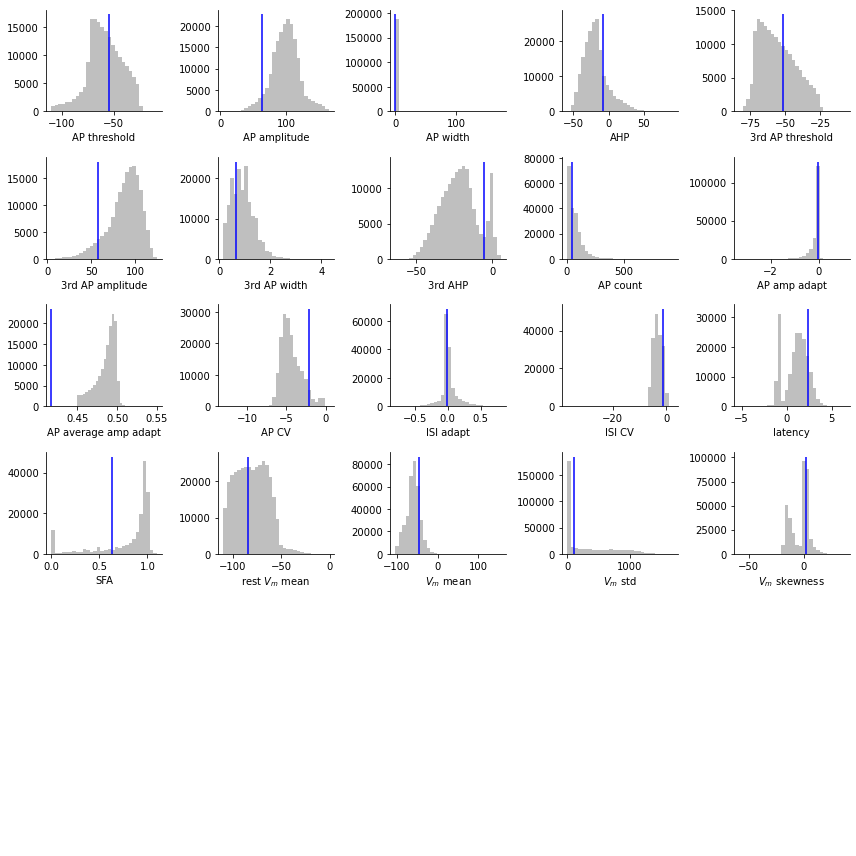

In [427]:
plot_summary_stats(stats_sim, stats_obs)

In [428]:
# select covered summary stats
#selected_indices = [0,1,2,3,4,5,6,7,9,10,11,15,17,18,19,20,21,23,24,25] # example for 8params
selected_indices = [0,1,2,3,4,5,6,7,9,11,12,13,14,15,16,17,18,19] # example for 10params v2
#selected_indices = [0,1,2,3,4,5,6,7,8,9,10,11,13,14,15,17,18,19,21,23,24,25] # example for 10params
selected_metrics = stats_sim.columns[selected_indices]
na_idx = stats_sim.T.isna().any()

# remove NaNs
stats_obs_selected = stats_obs[selected_metrics]
stats_sim_selected = stats_sim[selected_metrics].loc[~na_idx]
thetas_selected = params_sim.loc[~na_idx]

# normalise data
df_normal = normalise_df(stats_obs_selected.append(stats_sim_selected))
stats_obs_selected_norm = df_normal.iloc[0:1]
stats_sim_selected_norm = df_normal.iloc[1:]

print("{} samples and {} stats remain, after preparing the data".format(stats_sim_selected.shape[0],
                                                                            stats_sim_selected.shape[1]))

167232 samples and 18 stats remain, after preparing the data


## Learn an approximate Posterior

In [18]:
# define prior or re-use prior from earlier
#prior_min = [.5, 1e-4, 1e-4, 1e-4, 50, -90, -110, 0.1]
#prior_max = [80., 30, 0.6, 0.6, 3000, -40, -50, 3]
#prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
#                                    high=torch.as_tensor(prior_max))

# Set up and test simulator for integrity
#simulate_obs_trace = lambda params: simulate_and_summarise_batches(params, syn_current=trace_obs.get_syn_current(), 
#                                                                   selected_stats=None, summary_func="v1",
#                                                                   num_workers=2)

#simulator, prior = prepare_for_sbi(simulate_obs_trace, prior)

# choose neural density estimator (MDN, MAF or NSF)
# choosing MDN enables more flexible conditional analysis later
#density_estimator_build_fun = posterior_nn(model='mdn')

In [19]:
# learn a posterior distribution. 
#inference = SNPE(prior, density_estimator=density_estimator_build_fun, 
#                 show_progress_bars=True) # num_workers is not supported anymore

#density_estimator = inference.append_simulations(torch.as_tensor(thetas_selected.values, dtype=torch.float32), \
#                               torch.as_tensor(stats_sim_selected.values, dtype=torch.float32)).train()

#posterior = inference.build_posterior(density_estimator)  # MCMC kwargs go here.

In [164]:
# save trained posterior object
#estimator_type = "mdn"
#torch.save(posterior, "./trained_posteriors/{}_posterior_{}_{}params_{}".format(estimator_type,
#                                                                                ExpData.Description,
#                                                                                len(thetas_selected.columns),
#                                                                                num_sims))

In [18]:
# import a previously trained posterior object
estimator_type = "mdn"
num_params = 8 # 10 or 8 depending on if A_Soma and V0 were part of the prior
num_sims = 300000

posterior = torch.load("./trained_posteriors/{}_posterior_{}_{}params_{}".format(estimator_type,
                                                                             ExpData.Description,
                                                                             num_params,
                                                                             num_sims))

## Do Inference

In [19]:
# sample from approximate posterior
samples = posterior.sample((20000,), x=stats_obs_selected.values)

# pick examples of parameter samples
n_examples = 8
rnd_int = np.random.randint(0,samples.shape[0]-n_examples)
examples = samples[rnd_int:rnd_int+n_examples]

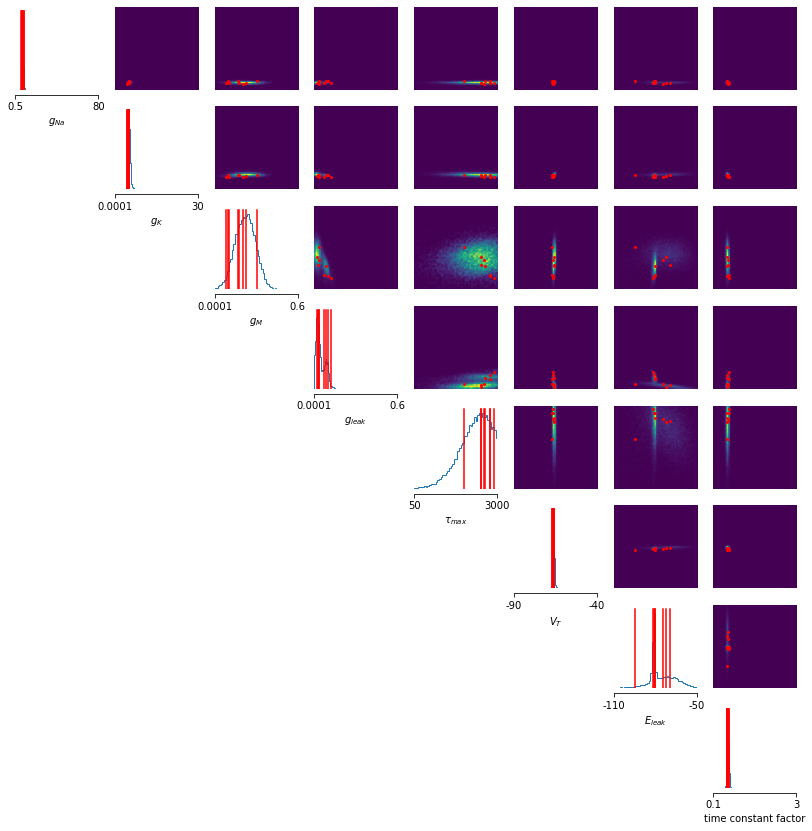

In [20]:
# show posterior and exemplary samples
fig, axes = pairplot(samples,
                     limits=list(zip(prior_min,prior_max)),
                     ticks=list(zip(prior_min,prior_max)),
                     points=examples,
                     figsize=(14,14),
                     labels=list(thetas_selected.columns),
                     points_offdiag={'markersize': 4, 'marker': ".", 'lw': 0},
                     points_colors="r")

#plt.savefig('./figures/{}/posterior_distribution_Iscale1.png'.format(cell_name))

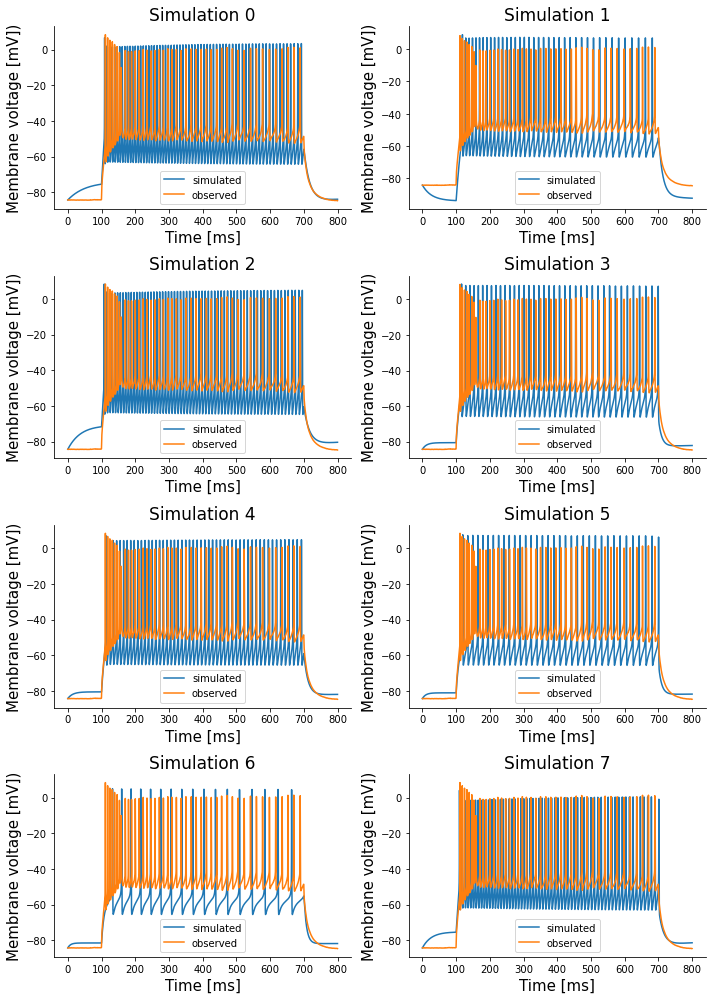

In [26]:
# sanity check for sensible posterior samples
# check how samples from the posterior look
example_traces = simulate_batches(examples,trace_obs, using="br2")
plot_comparison(example_traces,trace_obs,samplesize=n_examples)
plt.show()

In [27]:
# find highest posterior samples

# set the context
posterior.set_default_x(stats_obs_selected.values)

# sort samples by log_prob
most_probable_samples = np.array(np.argsort(posterior.log_prob(samples)))[::]
idx_p_max = most_probable_samples[0]
print("highest posterior probability by index", most_probable_samples)

highest posterior probability by index [ 5743 14064 11391 ...  4117  4753 12376]


WARNING    The expression "1 / 4" divides two integer values. In previous versions of Brian, this would have used either an integer ("flooring") or a floating point division, depending on the Python version and the code generation target. In the current version, it always uses a floating point division. Explicitly ask for an  integer division ("//"), or turn one of the operands into a floating point value (e.g. replace "1/2" by "1.0/2") to no longer receive this warning. [brian2.parsing.bast.floating_point_division]
WARNING    The expression "1 / 40" divides two integer values. In previous versions of Brian, this would have used either an integer ("flooring") or a floating point division, depending on the Python version and the code generation target. In the current version, it always uses a floating point division. Explicitly ask for an  integer division ("//"), or turn one of the operands into a floating point value (e.g. replace "1/2" by "1.0/2") to no longer receive this warning. [

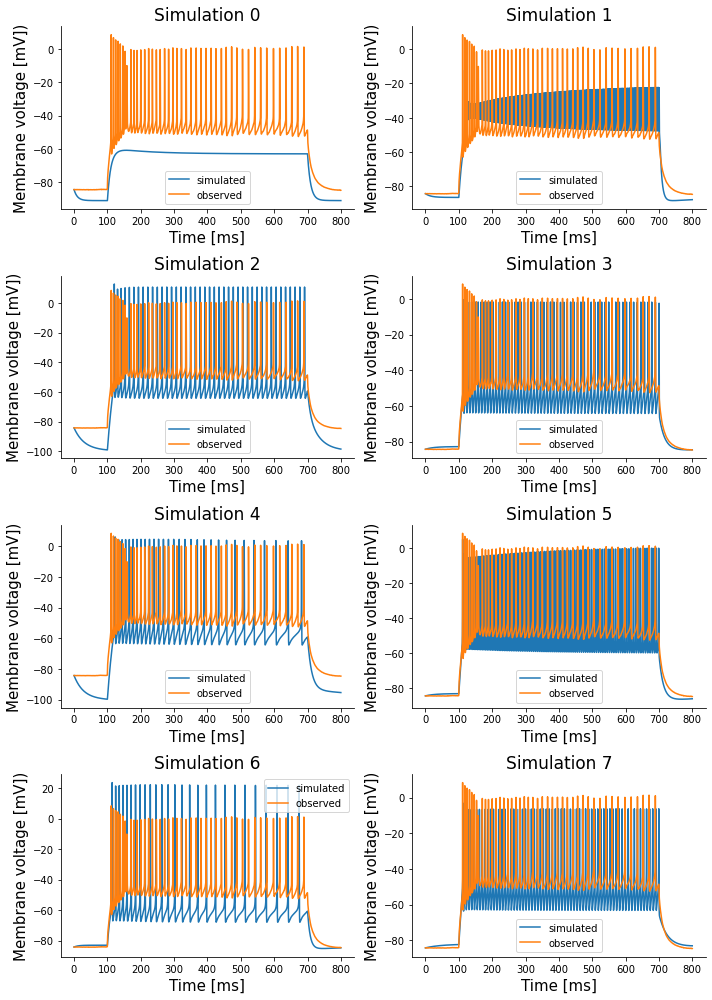

In [25]:
# check high posterior samples
example_traces_pmax = simulate_batches(samples.numpy()[most_probable_samples[:n_examples]],trace_obs, using="br2")
plot_comparison(example_traces_pmax,trace_obs,samplesize=n_examples)
plt.show()

## Analysis

In [29]:
small_sample = posterior.sample((2000,))
summarised_posterior_traces = simulate_and_summarise_batches(small_sample, trace_obs.get_syn_current(), 
                                                             using="br2", num_workers=2,
                                                             selected_stats=selected_indices)

In [30]:
# pick simulations from the posterior, that best match the observation
best_idxs, rad = best_matches(stats_sim=pd.DataFrame(summarised_posterior_traces),
                              trace_obs=trace_obs, selected_stats=selected_indices)

## Conditional Posterior

In [31]:
# condtion on the best matching trace
condition = small_sample[best_idxs[0]].reshape(1,-1)
print("logprob =", float(posterior.log_prob(condition)))

logprob = -9.351085662841797


WARNING    /home/jnsbck/Applications/anaconda3/envs/sbi_env/lib/python3.7/site-packages/sbi/utils/conditional_density.py:58: UserWarning: Importing `eval_conditional_density` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import eval_conditional_density`.
  "Importing `eval_conditional_density` from `sbi.utils` is deprecated since "
 [py.warnings]
WARNING    /home/jnsbck/Applications/anaconda3/envs/sbi_env/lib/python3.7/site-packages/sbi/utils/conditional_density.py:58: UserWarning: Importing `eval_conditional_density` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import eval_conditional_density`.
  "Importing `eval_conditional_density` from `sbi.utils` is deprecated since "
 [py.warnings]
WARNING    /home/jnsbck/Applications/anaconda3/envs/sbi_env/lib/python3.7/site-packages/sbi/utils/conditional_density.py:58: UserWarning: Importing `eval_conditional_density` from `sbi.utils` is deprecated since sbi v0.15.0. Inste

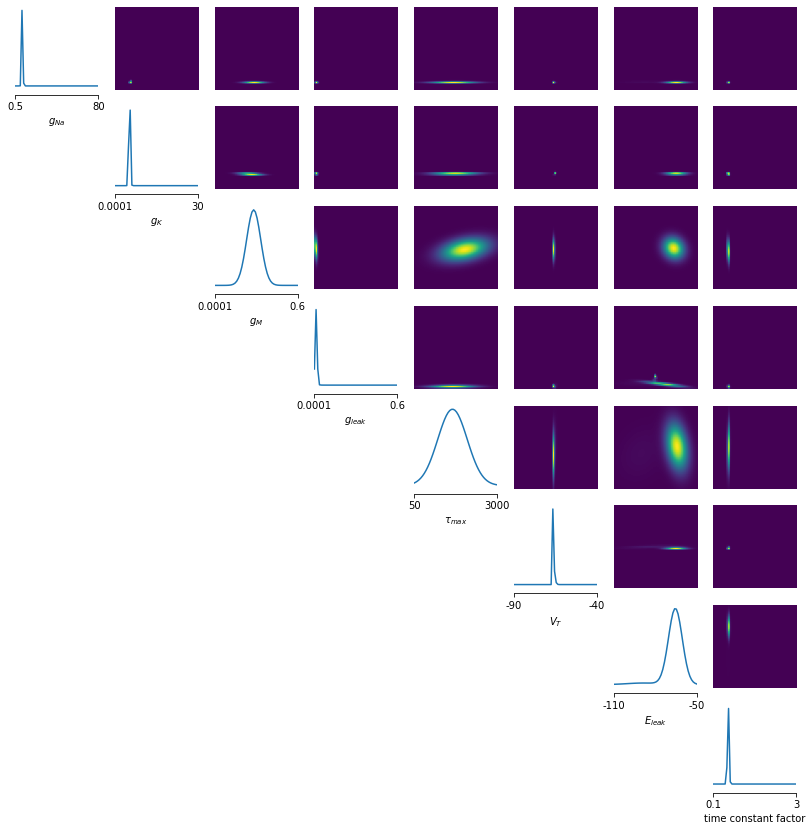

In [32]:
_ = conditional_pairplot(
    density=posterior,
    condition=condition,
    limits=list(zip(prior_min,prior_max)),
    ticks=list(zip(prior_min,prior_max)),
    figsize=(14,14),
    points_offdiag={'markersize': 6},
    points_colors='r',
    labels=list(thetas_selected.columns),
)

WARNING    /home/jnsbck/Applications/anaconda3/envs/sbi_env/lib/python3.7/site-packages/sbi/utils/conditional_density.py:58: UserWarning: Importing `eval_conditional_density` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import eval_conditional_density`.
  "Importing `eval_conditional_density` from `sbi.utils` is deprecated since "
 [py.warnings]


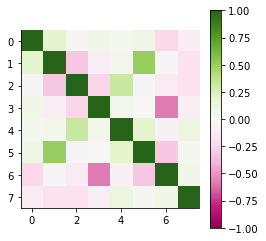

In [33]:
# look at correlation structure
cond_coeff_mat = conditional_corrcoeff(
                 density=posterior,
                 condition=condition,
                 limits=torch.Tensor(list(zip(prior_min,prior_max)))
)

fig, ax = plt.subplots(1,1, figsize=(4,4))
im = plt.imshow(cond_coeff_mat, clim=[-1, 1], cmap='PiYG')
_ = fig.colorbar(im)

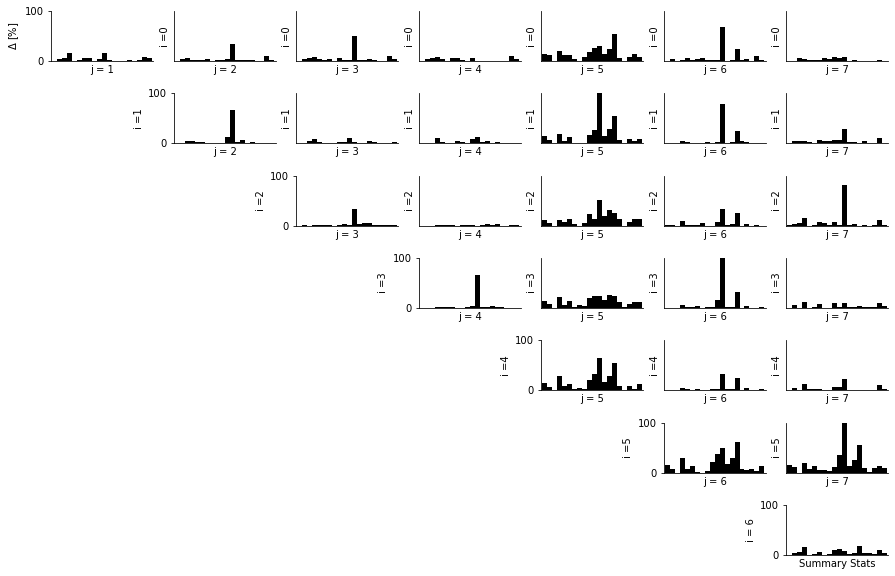

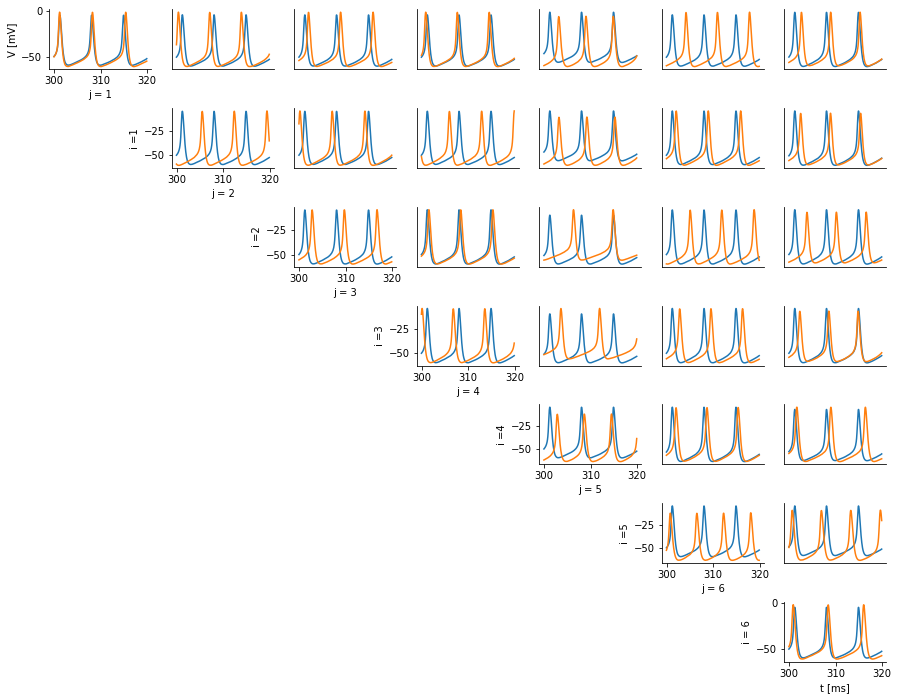

In [34]:
# look at potential correlation effects
plot_correlation_effects(condition, trace_obs.get_syn_current(), cond_coeff_mat, mag_of_change=0.1, figsize=(15,10), effect_on="summary_stats", selected_stats=selected_indices, mode="trace")
plot_correlation_effects(condition, trace_obs.get_syn_current(), cond_coeff_mat, mag_of_change=0.1, figsize=(15,12), timewindow=[0.3,0.32], effect_on="traces", mode="trace")

<Figure size 1080x720 with 0 Axes>

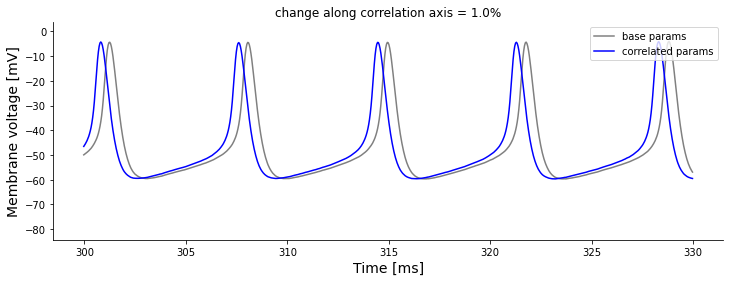

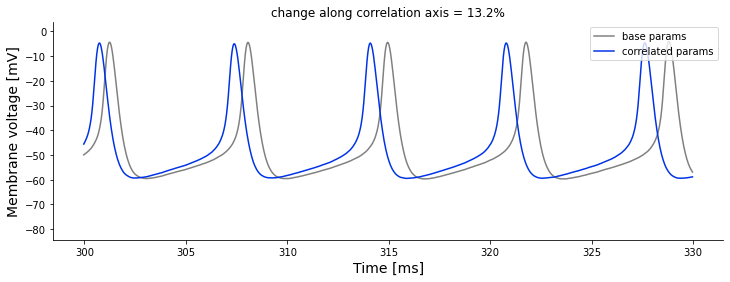

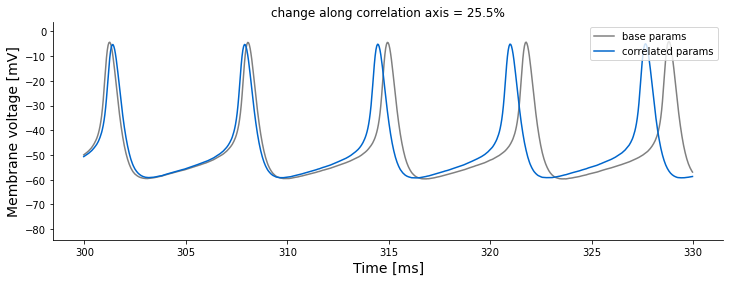

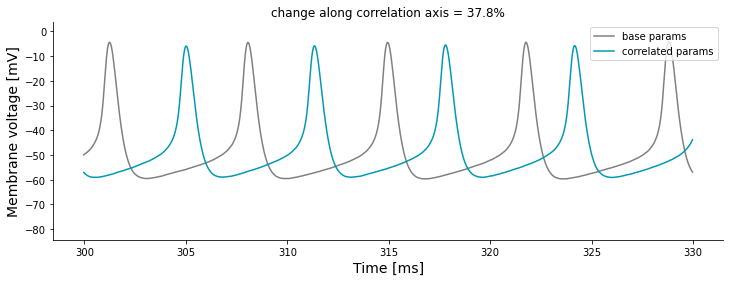

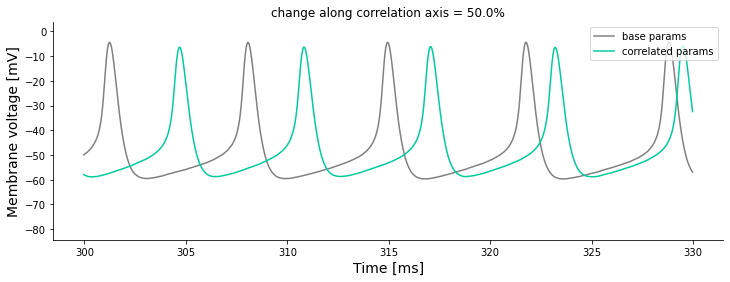

In [35]:
show_correlated_traces(condition, trace_obs.get_syn_current(), cond_coeff_mat, pair=(3,6))

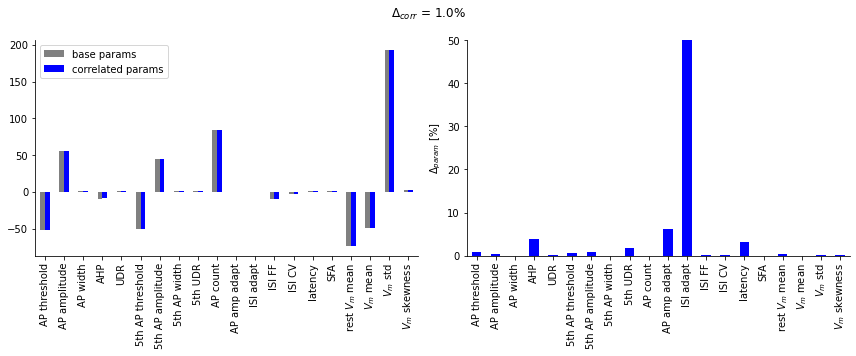

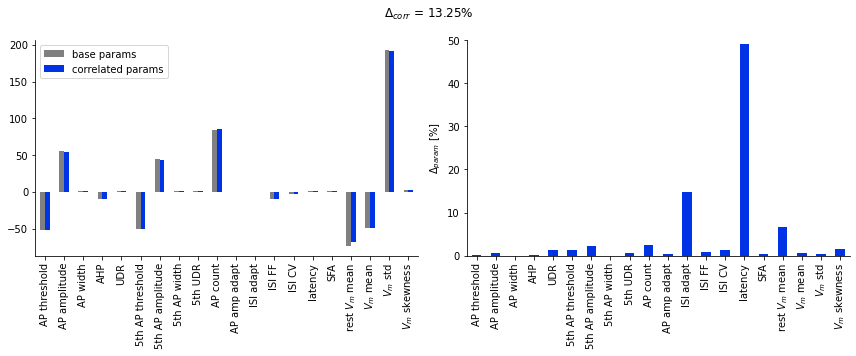

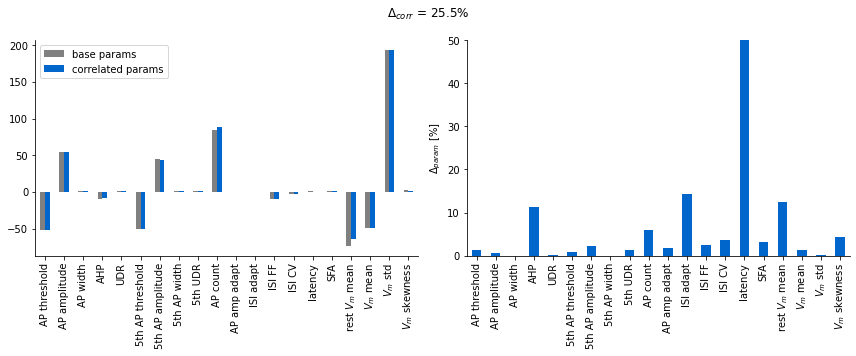

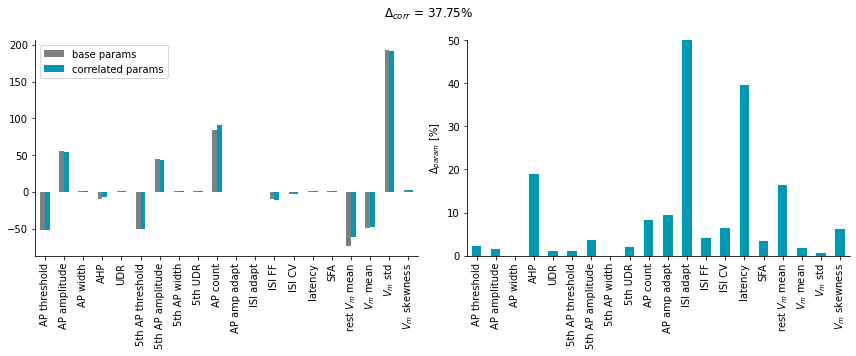

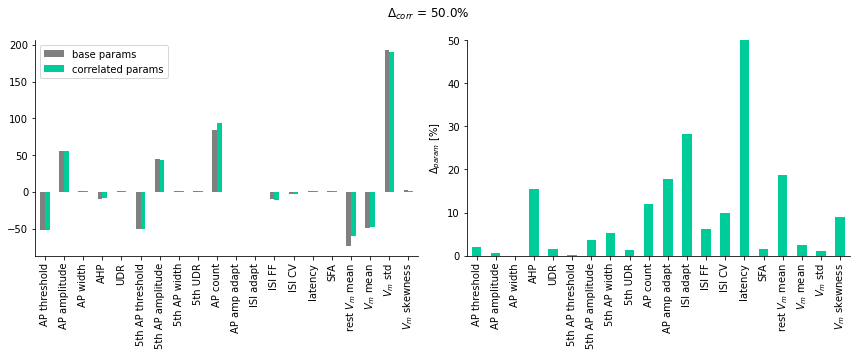

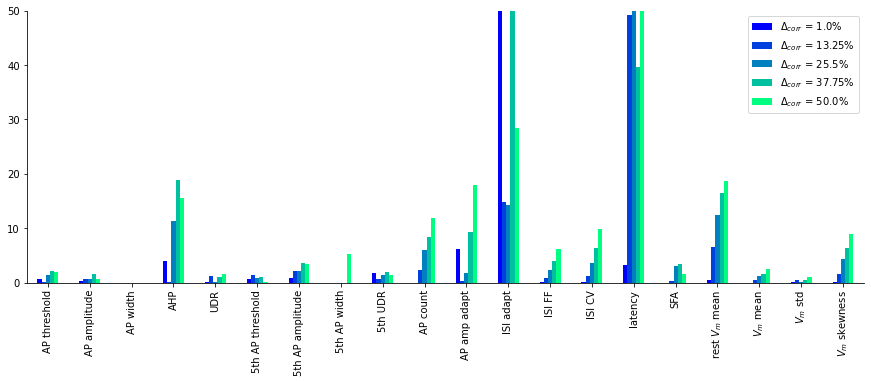

In [45]:
plot_correlated_summary_stats(condition, trace_obs.get_syn_current(), 
                              cond_coeff_mat, selected_stats=selected_indices, pair=(3,6))

In [47]:
# If an MDN was trained, MDNPosterior can be created for better conditioning and analysis
# in the case of the 10 param model, it makes sense to first condition on the measured values
# for V0 and ASoma
#mdn_posterior = MDNPosterior(posterior)
#condition = torch.ones([1,10])*np.nan
#condition[:,8] = trace_obs.get_syn_current()["V0"]
#condition[:,9] = ExpData.Cell.ASoma
#condition = mdn_posterior.sample((1,))
#condition[:,:-2] = np.nan

#cond_mdn_posterior = mdn_posterior.conditionalise(condition)

In [48]:
#cond_samples = cond_mdn_posterior.sample((10000,))

In [49]:
#fig, axes = pairplot(cond_samples,
#                     limits=list(zip(prior_min,prior_max))[:-2],
#                     ticks=list(zip(prior_min,prior_max))[:-2],
#                     figsize=(14,14),
#                     labels=list(thetas_selected.columns)[:-2],
#                     points_offdiag={'markersize': 6, 'marker': ".", 'lw': 0},
#                     points_colors="r")
#plt.savefig('./figures/{}/posterior_distribution_Iscale1.png'.format(cell_name))

In [52]:
# for the 8 param posterior we can now look which parameters offer the most room
# to potentially allow for compnesatory behaviour.
# Therefore we can condition on some of parameters from the best matching trace
features_of_interest = [2,3,4]

condition = small_sample[best_idxs[0]].reshape(1,-1).clone()
for i in features_of_interest:
    condition[:,i] = np.nan

print("condition = ", condition.numpy()[0])
# condition the mdn_posterior
mdn_posterior = MDNPosterior(posterior)
cond_mdn_posterior = mdn_posterior.conditionalise(condition)

condition =  [  6.6586776   4.551264          nan         nan         nan -65.92987
 -59.69371     0.5868836]


In [53]:
cond_samples = cond_mdn_posterior.sample((30000,))

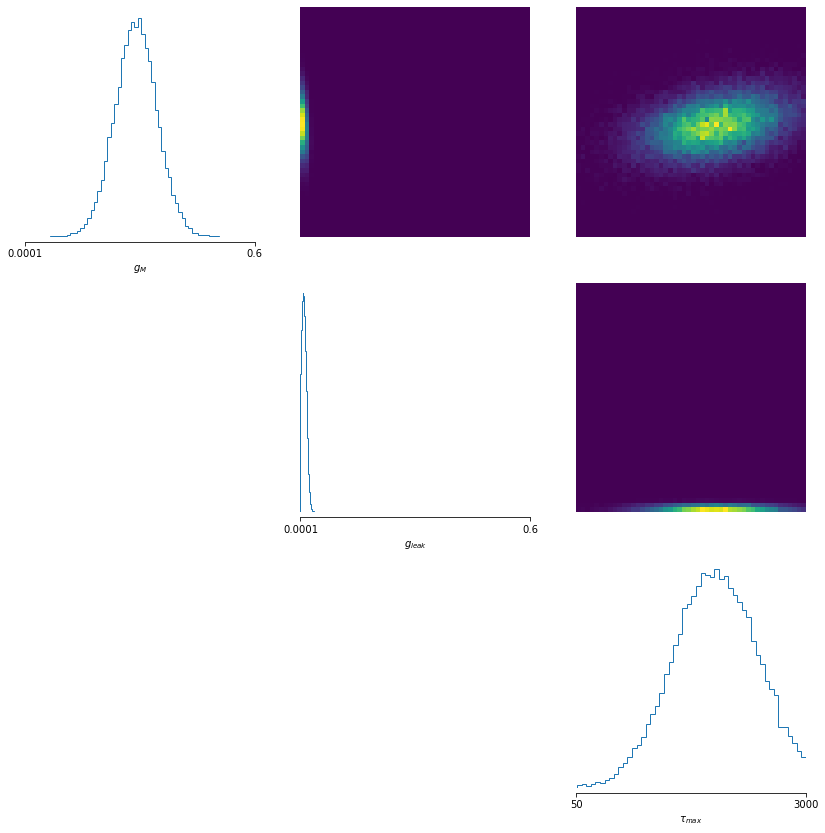

In [54]:
fig, axes = pairplot(cond_samples,
                           limits=list(np.array(list(zip(prior_min,prior_max)))[features_of_interest]),
                           ticks=list(np.array(list(zip(prior_min,prior_max)))[features_of_interest]),
                           figsize=(14,14),
                           labels=list(np.array(list(thetas_selected.columns))[features_of_interest]),
                           points_offdiag={'markersize': 6, 'marker': ".", 'lw': 0},
                           points_colors="r")
#plt.savefig('./figures/{}/posterior_distribution_Iscale1.png'.format(cell_name))

In [272]:
# combining conditional samples with the parameters of the original condition
# to simulate conditional samples
cond_params = torch.repeat_interleave(condition, cond_samples.shape[0], dim=0)
cond_params[:,condition.isnan().reshape(-1)] = cond_samples

In [273]:
summarised_posterior_traces = simulate_and_summarise_batches(cond_params[:5000], 
                                                             syn_current=trace_obs.get_syn_current(), 
                                                             using="br2", selected_stats=selected_indices,
                                                             num_workers=2)

In [274]:
# pick simulations from the posterior, that best match the observation
idxs, rad = best_matches(stats_sim=pd.DataFrame(summarised_posterior_traces),
                         trace_obs=trace_obs, selected_stats=selected_indices)

In [278]:
# select two suitable points for path i.e. theta_s and theta_g
r_accept = 1100 #stds
close_params = cond_params[idxs[rad < r_accept]]
close_params = close_params[:,features_of_interest]

print("N accepted parameters = {}".format(len(close_params)))
ij = greatest_distance(close_params)

N accepted parameters = 771


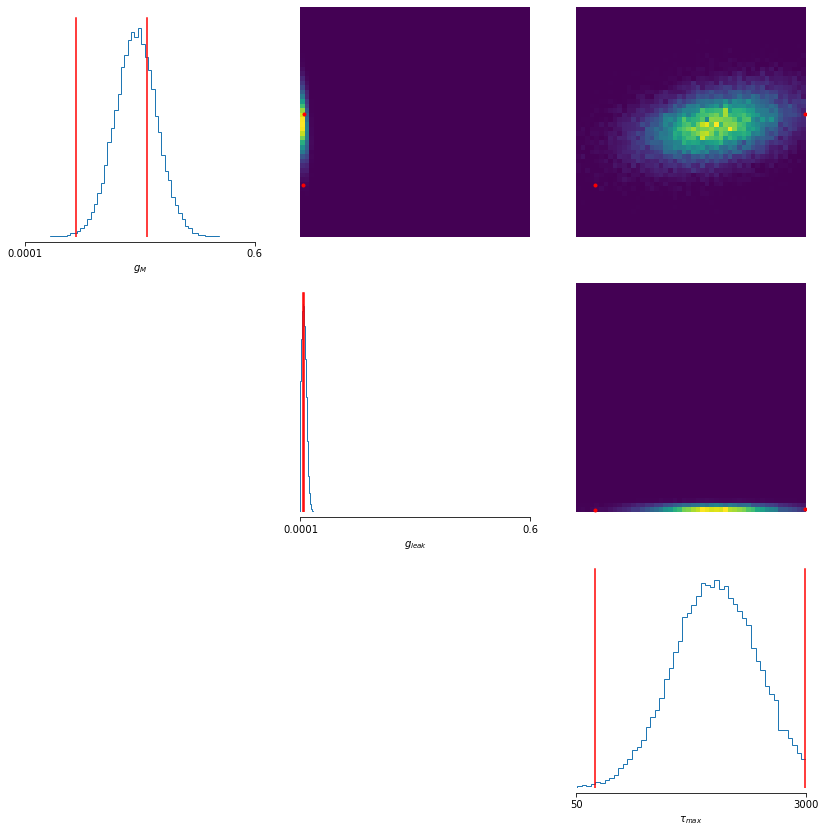

In [279]:
fig, axes = pairplot(cond_samples,
                           limits=list(np.array(list(zip(prior_min,prior_max)))[features_of_interest]),
                           ticks=list(np.array(list(zip(prior_min,prior_max)))[features_of_interest]),
                           points=close_params[[ij]],
                           figsize=(14,14),
                           labels=list(np.array(list(thetas_selected.columns))[features_of_interest]),
                           points_offdiag={'markersize': 6, 'marker': ".", 'lw': 0},
                           points_colors="r")
#plt.savefig('./figures/{}/posterior_distribution_Iscale1.png'.format(cell_name))

In [280]:
theta_s, theta_g = close_params[[ij]]

Progress: (1500/1500)

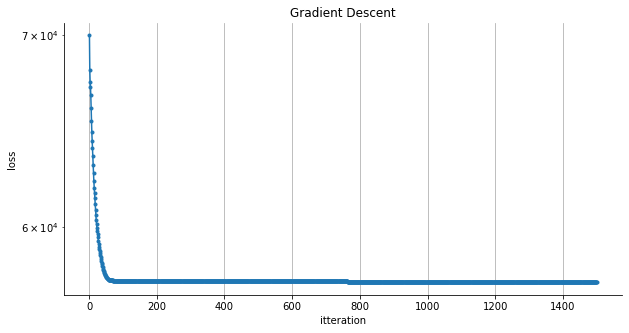

In [283]:
# fit  high posterior path!
path = fit_high_posterior_path(theta_s,theta_g, 
                               cond_mdn_posterior, 
                               cond_mdn_posterior.default_x,n_points=8, n_itters=1500, init_size=1e-4)

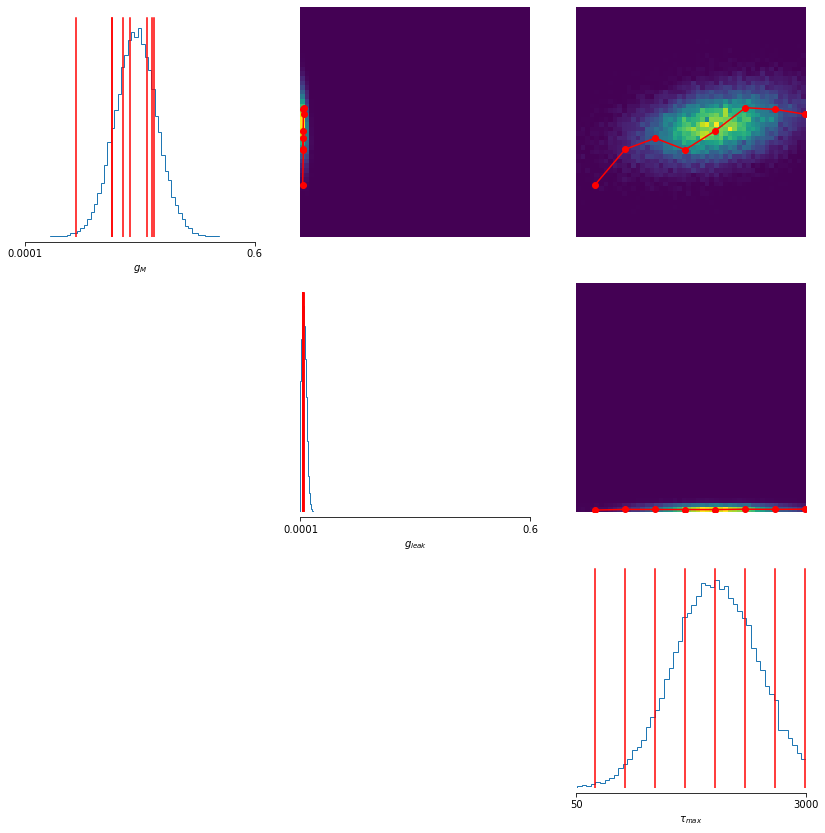

In [284]:
fig, axes = pairplot(cond_samples,
                           limits=list(np.array(list(zip(prior_min,prior_max)))[features_of_interest]),
                           ticks=list(np.array(list(zip(prior_min,prior_max)))[features_of_interest]),
                           points=path,
                           figsize=(14,14),
                           labels=list(np.array(list(thetas_selected.columns))[features_of_interest]),
                           points_offdiag={'markersize': 6, 'marker': "o"},
                           points_colors="r")
#plt.savefig('./figures/{}/posterior_distribution_Iscale1.png'.format(cell_name))

In [285]:
# combining conditional samples with the parameters of the original condition
# to simulate conditional samples
cond_params = torch.repeat_interleave(condition, path.shape[0], dim=0)
cond_params[:,condition.isnan().reshape(-1)] = path

In [286]:
conditional_highp_traces = simulate_batches(cond_params,trace_obs, using="br2", batch_size=4)

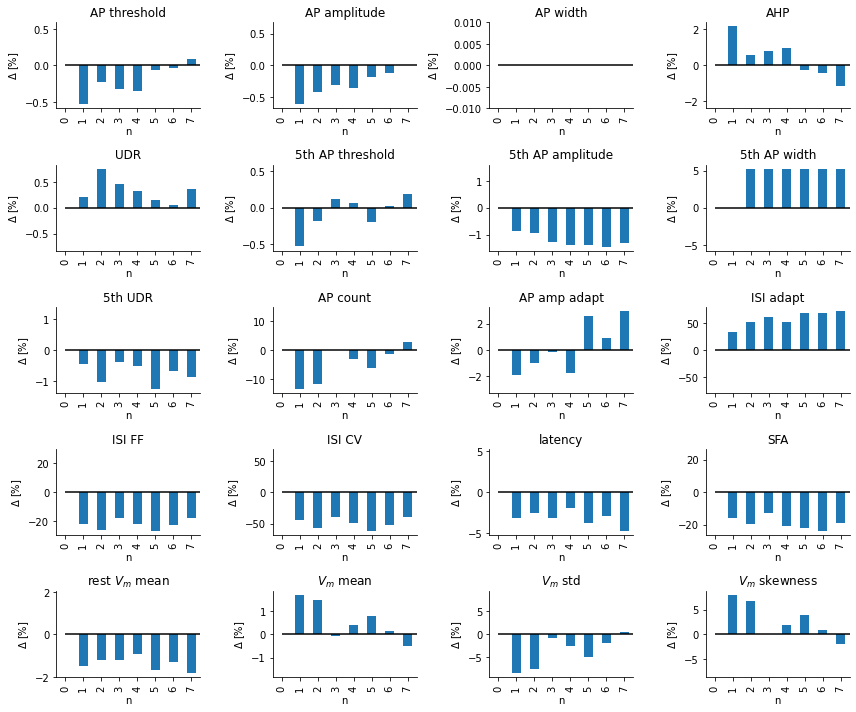

In [410]:
# looking whether the high posterior traces show any sign of compensation
plot_comparison(conditional_highp_traces, trace_obs, samplesize=8, figsize=(10,10), effect_on="summary_stats", selected_stats=selected_indices)